# Visualize regulon activity and expression dynamics

# Library import

In [ ]:
import decoupler as dc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import cellrank as cr
import scanpy as sc

from rgv_tools import DATA_DIR, FIG_DIR

## General settings

In [2]:
plt.rcParams["svg.fonttype"] = "none"

## Constants

In [3]:
DATASET = "zebrafish"

In [4]:
SAVE_DATA = True
SAVE_FIGURE = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)
if SAVE_FIGURE:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [5]:
TERMINAL_STATES = [
    "mNC_head_mesenchymal",
    "mNC_arch2",
    "mNC_hox34",
    "Pigment",
]

genes = ["nr2f5", "sox9b", "twist1b", "ets1"]

## Define functions

In [6]:
def min_max_scaling(data):
    """Compute min and max values for each feature."""
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)

    # Perform min-max scaling
    scaled_data = (data - min_vals) / (max_vals - min_vals)

    return scaled_data

## Data loading

In [28]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")

## Calculate activity

In [8]:
regulons = (
    adata.uns["skeleton"]
    .copy()
    .reset_index()
    .melt(id_vars="index", var_name="target", value_name="weight")
    .rename(columns={"index": "source"})
)
regulons = regulons[regulons["weight"] != 0].reset_index(drop=True)

In [9]:
dc.mt.aucell(adata, layer="Ms", net=regulons, tmin=0)

activity = adata.obsm["score_aucell"].copy()

dc.mt.aucell(adata, layer="Ms", net=regulons, tmin=0, n_up=np.floor(988 * 0.50))  # considering the small regulon
activity_50 = adata.obsm["score_aucell"].copy()

connectivity = adata.uns["skeleton"].loc[activity.columns, :].sum(1)

activity_merge = []

for i in connectivity.index:
    if connectivity[i] < 50:  # if regulon gene less than 50, used top 50% genes
        activity_merge.append(activity_50[i])
    else:
        activity_merge.append(activity[i])

In [10]:
activity = adata.obsm["score_aucell"].copy()
activity = pd.DataFrame(np.array(activity_merge), index=connectivity.index, columns=activity.index)
adata.obsm["score_aucell"] = activity.T.copy()

In [16]:
activity = pd.DataFrame(np.zeros(adata.shape), index=adata.obs_names, columns=adata.var_names)
activity.loc[:, adata.obsm["score_aucell"].columns] = adata.obsm["score_aucell"].values.copy()

adata.layers["activity"] = np.array(activity)

## GAM fitting

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-25 18:34:38 | [INFO] Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


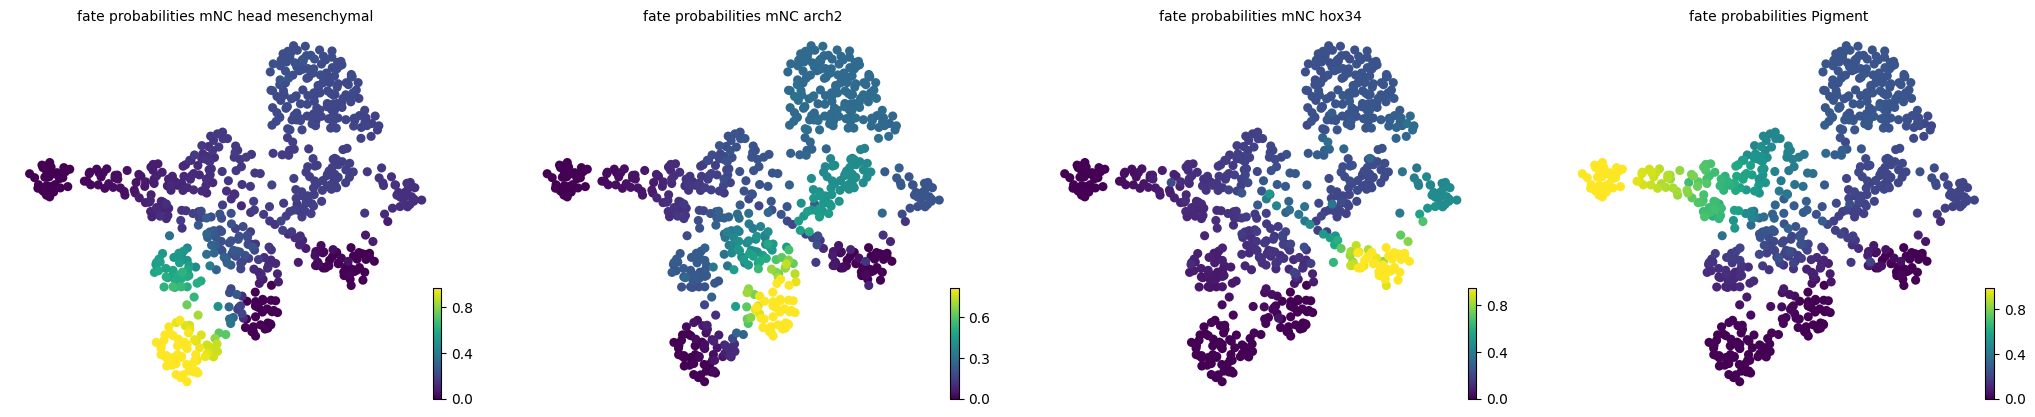

In [17]:
pk = cr.kernels.PseudotimeKernel(adata, time_key="latent_time").compute_transition_matrix()
estimator = cr.estimators.GPCCA(pk)

estimator.compute_macrostates(n_states=7, n_cells=30, cluster_key="cell_type")
estimator.set_terminal_states(TERMINAL_STATES)

estimator.compute_fate_probabilities()
estimator.plot_fate_probabilities(same_plot=False)

In [18]:
model = cr.models.GAMR(adata, n_knots=6, smoothing_penalty=10.0)

2025-10-25 18:35:11 | [INFO] cffi mode is CFFI_MODE.ANY
2025-10-25 18:35:11 | [INFO] R home found: /usr/lib64/R
2025-10-25 18:35:11 | [INFO] R library path: :/home/icb/weixu.wang/miniconda3/lib
2025-10-25 18:35:11 | [INFO] LD_LIBRARY_PATH: :/home/icb/weixu.wang/miniconda3/lib
2025-10-25 18:35:12 | [INFO] Default options to initialize R: rpy2, --quiet, --no-save
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "BASH_FUNC_which%%" redefined by R and overriding existing variable. Current: "() {  ( alias;
 eval ${which_declare} ) | /usr/bin/which --tty-only --read-alias --read-functions --show-tilde --show-dot $@
}", R: "() {  ( alias; eval ${which_declare} ) | /usr/bin/which --tty-only --read-alias --read-functions --show-tilde --show-dot $@}"
  warnings.warn(
sh: which: line 1: syntax error: unexpected end of file
sh: error importing function definition for `which'
sh: which: line 1: syntax

## Visualize activity

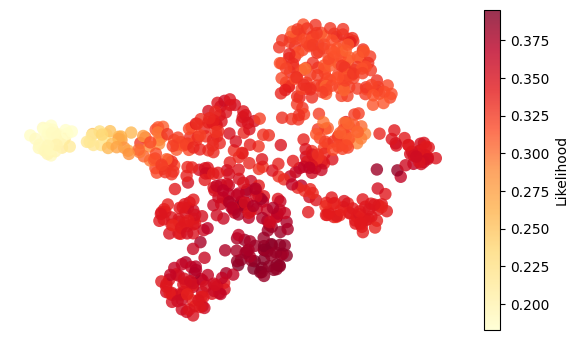

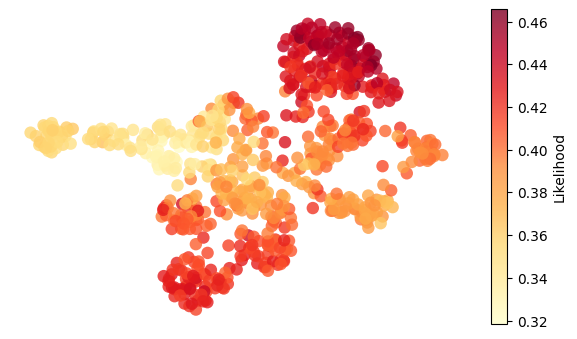

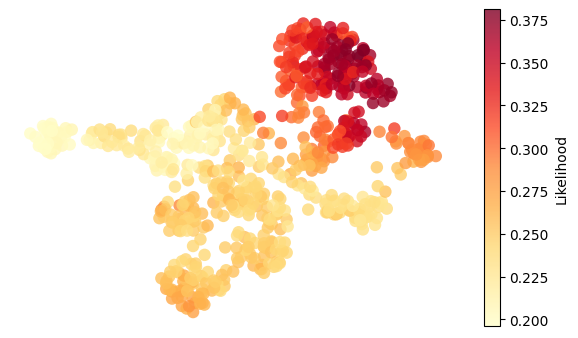

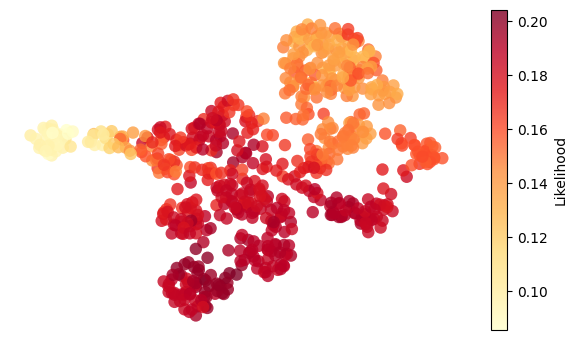

In [22]:
for g in ["nr2f5", "twist1b", "sox9b", "ets1"]:
    adata.obs["activity"] = adata.obsm["score_aucell"][g]

    umap = adata.obsm["X_umap"]
    activity = adata.obs["activity"]

    fig, ax = plt.subplots(figsize=(6, 3.5))

    # Plot all cells colored by "likelihood"
    scc = ax.scatter(
        umap[:, 0],
        umap[:, 1],
        c=activity,
        cmap="YlOrRd",
        # s=20,
        edgecolors="none",
        alpha=0.8,
        s=80,
    )

    # Overlay highlighted cells (larger, outlined)

    # Add colorbar
    plt.colorbar(scc, ax=ax, label="Likelihood")

    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.axis("off")
    plt.tight_layout()
    plt.show()

    if SAVE_FIGURE:
        fig.savefig(FIG_DIR / DATASET / f"{g}_activity.svg", format="svg", transparent=True, bbox_inches="tight")

  0%|          | 0/4 [00:00<?, ?gene/s]

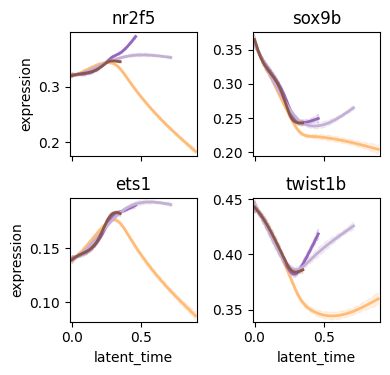

In [24]:
cr.pl.gene_trends(
    adata,
    model=model,
    data_key="activity",
    genes=["nr2f5", "sox9b", "ets1", "twist1b"],
    same_plot=True,
    ncols=2,
    time_key="latent_time",
    hide_cells=True,
    weight_threshold=(1e-3, 1e-3),
    figsize=(4, 4),
    legend_loc="none",
)

## Plot regulatory circut dynamics

### refit using velocity kernel

In [29]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

kernel = 0.8 * vk + 0.2 * ck

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


In [30]:
estimator = cr.estimators.GPCCA(kernel)
estimator.compute_macrostates(n_states=7, n_cells=30, cluster_key="cell_type")
estimator.set_terminal_states(TERMINAL_STATES)

2025-10-25 18:42:32 | [INFO] Using pre-computed Schur decomposition


GPCCA[kernel=(0.8 * VelocityKernel[n=697] + 0.2 * ConnectivityKernel[n=697]), initial_states=None, terminal_states=['Pigment', 'mNC_arch2', 'mNC_head_mesenchymal', 'mNC_hox34']]

  0%|          | 0/4 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


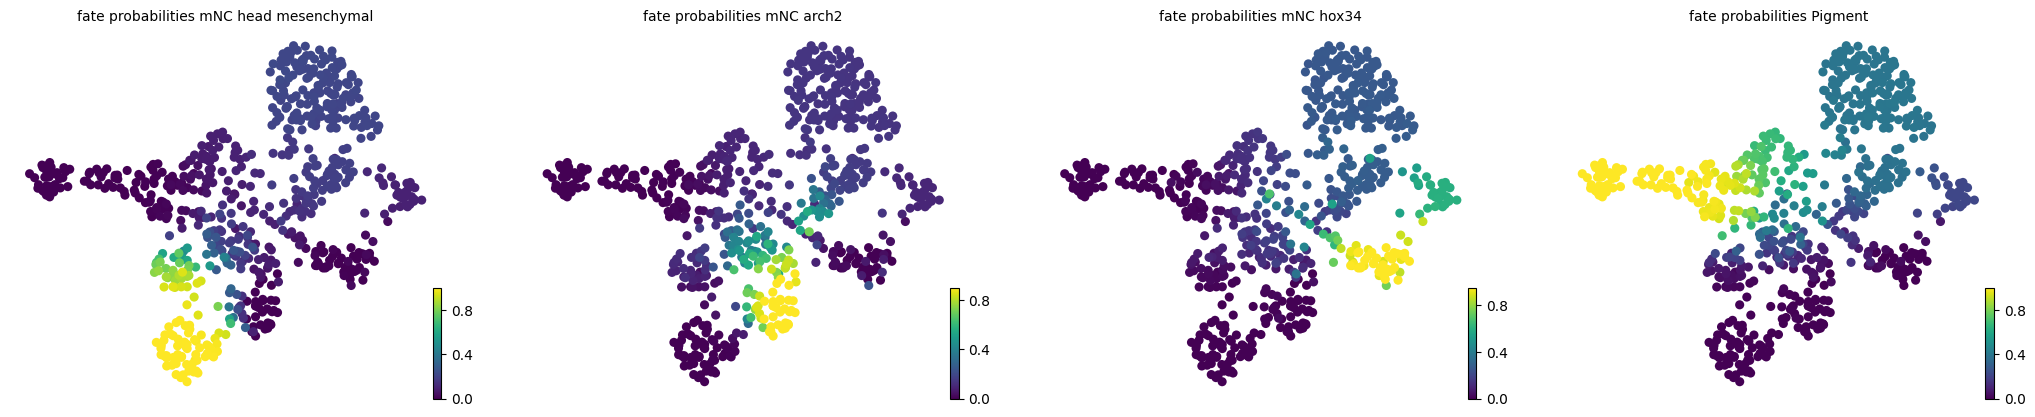

In [31]:
estimator.compute_fate_probabilities()
estimator.plot_fate_probabilities(same_plot=False)

### Plot following regulatory circut
    - nr2f5 -> serpinh1b
    - nr2f5 -> alcama

In [41]:
display = pd.DataFrame(np.zeros(adata.shape), index=adata.obs_names, columns=adata.var_names)
display.loc[:, "nr2f5"] = np.array(adata[:, "nr2f5"].layers["Ms"].reshape(-1))

display.loc[:, ["serpinh1b", "alcama"]] = np.array(adata[:, ["serpinh1b", "alcama"]].layers["Mu"])

In [42]:
adata.layers["display"] = np.array(display)

In [43]:
model = cr.models.GAMR(adata, n_knots=10, smoothing_penalty=10.0)

  0%|          | 0/3 [00:00<?, ?gene/s]

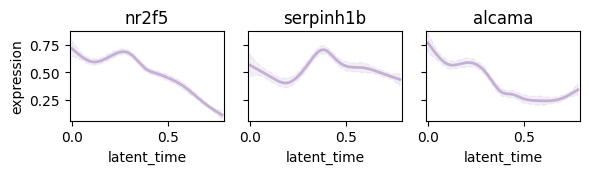

In [44]:
cr.pl.gene_trends(
    adata,
    model=model,
    lineages="mNC_head_mesenchymal",
    data_key="display",
    genes=["nr2f5", "serpinh1b", "alcama"],
    same_plot=True,
    ncols=3,
    time_key="latent_time",
    hide_cells=True,
    weight_threshold=(1e-3, 1e-3),
    legend_loc="none",
    sharey=True,
    figsize=(6, 2),
)

### Plot following regulatory circut
    - sox9b -> pdgfra
    - sox9b -> zfhx3

In [36]:
display = pd.DataFrame(np.zeros(adata.shape), index=adata.obs_names, columns=adata.var_names)
display.loc[:, "sox9b"] = np.array(adata[:, "sox9b"].layers["Ms"].reshape(-1))

display.loc[:, ["pdgfra", "zfhx3"]] = np.array(adata[:, ["pdgfra", "zfhx3"]].layers["Mu"])

In [37]:
adata.layers["display"] = np.array(display)

  0%|          | 0/3 [00:00<?, ?gene/s]

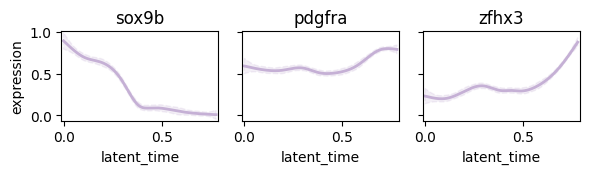

In [40]:
cr.pl.gene_trends(
    adata,
    model=model,
    lineages="mNC_head_mesenchymal",
    data_key="display",
    genes=["sox9b", "pdgfra", "zfhx3"],
    same_plot=True,
    ncols=3,
    time_key="latent_time",
    hide_cells=True,
    weight_threshold=(1e-3, 1e-3),
    legend_loc="none",
    sharey=True,
    figsize=(6, 2),
)

### Plot following regulatory circut
    - ets1 -> plpp3
    - ets1 -> ccn2a

In [45]:
display = pd.DataFrame(np.zeros(adata.shape), index=adata.obs_names, columns=adata.var_names)
display.loc[:, "ets1"] = np.array(adata[:, "ets1"].layers["Ms"].reshape(-1))

display.loc[:, ["plpp3", "ccn2a"]] = np.array(adata[:, ["plpp3", "ccn2a"]].layers["Mu"])

In [46]:
adata.layers["display"] = np.array(display)

  0%|          | 0/3 [00:00<?, ?gene/s]

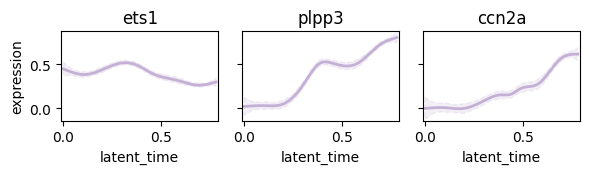

In [47]:
cr.pl.gene_trends(
    adata,
    model=model,
    lineages="mNC_head_mesenchymal",
    data_key="display",
    genes=["ets1", "plpp3", "ccn2a"],
    same_plot=True,
    ncols=3,
    time_key="latent_time",
    hide_cells=True,
    weight_threshold=(1e-3, 1e-3),
    legend_loc="none",
    sharey=True,
    figsize=(6, 2),
)

### Plot following regulatory circut
    - twist1b -> cbfb
    - twist1b -> wee1

In [48]:
display = pd.DataFrame(np.zeros(adata.shape), index=adata.obs_names, columns=adata.var_names)
display.loc[:, "twist1b"] = np.array(adata[:, "twist1b"].layers["Ms"].reshape(-1))

display.loc[:, ["cbfb", "wee1"]] = np.array(adata[:, ["cbfb", "wee1"]].layers["Mu"])

In [49]:
adata.layers["display"] = np.array(display)

  0%|          | 0/3 [00:00<?, ?gene/s]

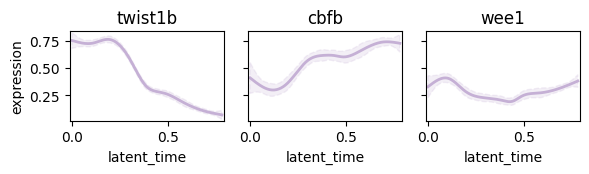

In [50]:
cr.pl.gene_trends(
    adata,
    model=model,
    lineages="mNC_head_mesenchymal",
    data_key="display",
    genes=["twist1b", "cbfb", "wee1"],
    same_plot=True,
    ncols=3,
    time_key="latent_time",
    hide_cells=True,
    weight_threshold=(1e-3, 1e-3),
    legend_loc="none",
    sharey=True,
    figsize=(6, 2),
)